In [55]:
import sys, os, argparse, numpy as np, logging, pandas as pd
from sklearn.externals import joblib
from copy import deepcopy
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [56]:
# Load our modules
from constants import *
# this_dir = os.path.dirname(__file__)
# sys.path.append(os.path.join(this_dir, '../../src'))
sys.path.append('../../src')
from i_o import get_logger


In [57]:
args = argparse.Namespace()
args.feature_files=[
    'output-base/collins-roguev-sc-sp/features/sc-features-no_landmarks.pkl',
    'output-base/collins-roguev-sc-sp/features/sp-features-no_landmarks.pkl']
args.names = ['sc', 'sp']
args.lmk_feature_files=[
    'output-base/collins-roguev-sc-sp/features/sc-features-w_landmarks.pkl',
    'output-base/collins-roguev-sc-sp/features/sp-features-w_landmarks.pkl']
args.nozero = False
args.source_to_target = False


In [58]:
args.gi_files = ['../../data/gi/collins/sc/collins-sc-emap-gis-std.tsv', 
                '../../data/gi/roguev/sp/roguev-sp-emap-gis-std.tsv']
args.embedding_files = ['output-base/collins-roguev-sc-sp/embeddings/sc-HANDL-embedding.pkl',
                       'output-base/collins-roguev-sc-sp/embeddings/sp-HANDL-embedding.pkl']

In [59]:
obj = joblib.load(args.embedding_files[0])
embedding_S = obj.get('X')
nodes_S = obj.get('nodes')
landmarks_S = obj.get('landmarks')
n_nodes_S = len(nodes_S)
nodeToIndex_S = dict(zip(nodes_S, range(n_nodes_S)))

In [60]:
obj = joblib.load(args.embedding_files[1])
embedding_T = obj.get('X')
nodes_T = obj.get('nodes')
landmarks_T = obj.get('landmarks')
n_nodes_T = len(nodes_T)
nodeToIndex_T = dict(zip(nodes_T, range(n_nodes_T)))

In [61]:
embed_S_ctrd = sklearn.preprocessing.scale(embedding_S, with_std = False)
embed_T_ctrd = sklearn.preprocessing.scale(embedding_T, with_std = False)

In [62]:
land_embed_S_ctrd = embed_S_ctrd[[nodeToIndex_S[nd] for nd in landmarks_S]]
land_embed_T_ctrd = embed_T_ctrd[[nodeToIndex_T[nd] for nd in landmarks_T]]

## CCA and PLS

Best settings so far:
- PLSCanonical, 20 - 100 components, C = 50, f1 = .21
- CCA, 20 components, no scaling after transform, C = 1000, f1 = .22

In [63]:
from sklearn.cross_decomposition import CCA, PLSCanonical
cca = CCA(n_components=20)
cca.fit(land_embed_S_ctrd, land_embed_T_ctrd)

CCA(copy=True, max_iter=500, n_components=20, scale=True, tol=1e-06)

In [64]:
X_c, Y_c = cca.transform(land_embed_S_ctrd, land_embed_T_ctrd)

In [65]:
# X_c = sklearn.preprocessing.scale(X_c)
# Y_c = sklearn.preprocessing.scale(Y_c)

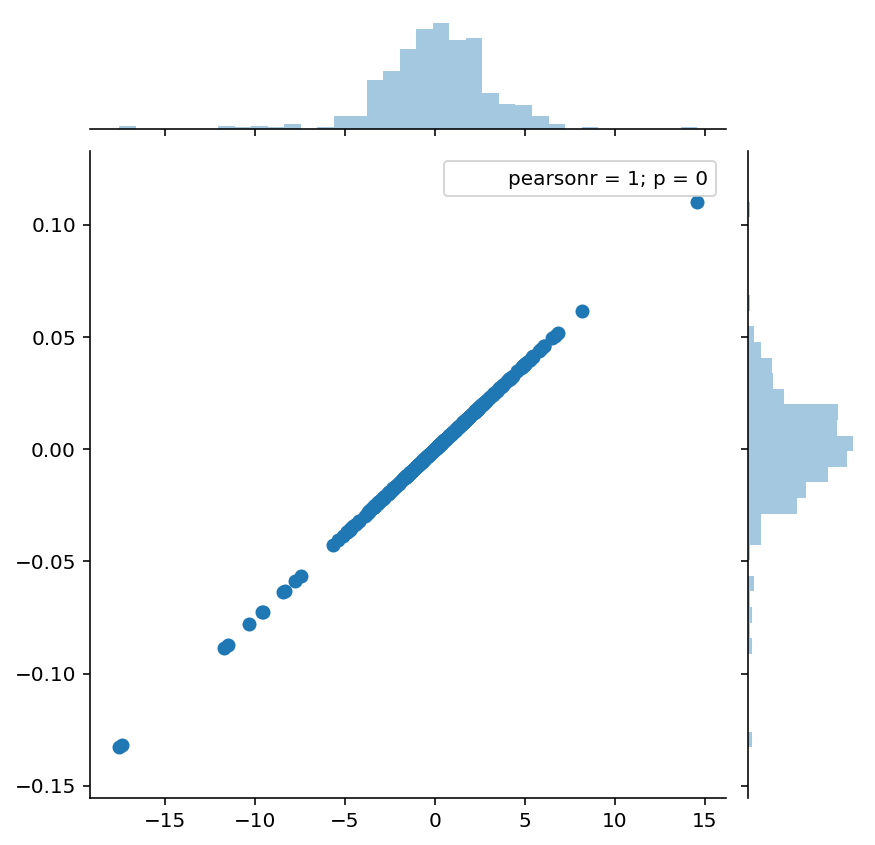

In [66]:
sns.jointplot(X_c[:,1], Y_c[:,1])

In [67]:
new_S, new_T = cca.transform(embed_S_ctrd, embed_T_ctrd)

In [68]:
joblib.dump(dict(X=new_S, nodes=nodes_S, 
                 landmarks=landmarks_S, weight=None), 'tmpfile1')
joblib.dump(dict(X=new_T, nodes=nodes_T, 
                 landmarks=landmarks_T, weight=None), 'tmpfile2')

['tmpfile2']

In [73]:
%run featurize_sls.py -ef 'tmpfile1' -gif {args.gi_files[0]} \
-o {args.lmk_feature_files[0]} 
# --remove-landmarks
%run featurize_sls.py -ef 'tmpfile2' -gif {args.gi_files[1]} \
-o {args.lmk_feature_files[1]} 
# --remove-landmarks

2018-03-11 22:00:35,443 featurize_sls.py INFO      : [Loading genetic interactions file]
2018-03-11 22:00:35,754 featurize_sls.py INFO      : - Loaded 131881 interactions (7210 SL and 124671 non-SL)
2018-03-11 22:00:35,755 featurize_sls.py INFO      : [Loading HANDL embedding]
2018-03-11 22:00:35,770 featurize_sls.py INFO      : - 5609 nodes
2018-03-11 22:00:35,770 featurize_sls.py INFO      : - 400 landmarks
2018-03-11 22:00:35,830 featurize_sls.py INFO      : - Restricting to 129385 pairs in the network
2018-03-11 22:00:38,670 featurize_sls.py INFO      : [Loading genetic interactions file]
2018-03-11 22:00:38,794 featurize_sls.py INFO      : - Loaded 103906 interactions (5605 SL and 98301 non-SL)
2018-03-11 22:00:38,794 featurize_sls.py INFO      : [Loading HANDL embedding]
2018-03-11 22:00:38,802 featurize_sls.py INFO      : - 1865 nodes
2018-03-11 22:00:38,802 featurize_sls.py INFO      : - 400 landmarks
2018-03-11 22:00:38,844 featurize_sls.py INFO      : - Restricting to 24214 p

In [74]:
src_data = joblib.load(args.lmk_feature_files[0])
tgt_data = joblib.load(args.lmk_feature_files[1])

X_S, y_S = np.array(src_data.get('X')), src_data.get('y')
S_pairs, S_name = src_data.get('pairs'), args.names[0]
S_args = src_data.get('args')
X_T, y_T = np.array(tgt_data.get('X')), tgt_data.get('y')
T_pairs, T_name = tgt_data.get('pairs'), args.names[1]
T_args = tgt_data.get('args')

In [75]:
np.random.seed(3)

# We are going to use balanced training
T_sample = np.random.choice(np.where(y_S)[0], 1000)
F_sample = np.random.choice(np.where(~y_S)[0], 1000)
sample = np.concatenate((T_sample,F_sample))

print('X_S is {} by {} with {} positives'.format(X_S.shape[0], X_S.shape[1], np.sum(y_S)))
print('X_T is {} by {} with {} positives'.format(X_T.shape[0], X_T.shape[1], np.sum(y_T)))
# only use the first 100 features

XS = X_S[sample]
yS = y_S[sample]

XS_full = X_S
yS_full = y_S

# and imbalanced testing to match previous results
T_sample = np.random.choice(np.where(y_T)[0], 1000)
F_sample = np.random.choice(np.where(~y_T)[0], 1000)
sample = np.concatenate((T_sample,F_sample))

XT_full = X_T
yT_full = y_T

XT = X_T[sample]
yT = y_T[sample]

X_S is 129385 by 20 with 7112 positives
X_T is 24214 by 20 with 2556 positives


C: 0.01 training precision: 0.002793296089385475 recall: 0.00014060742407199101 f1: 0.0002677376171352075
C: 0.01 testing precision: 0.16764821358460935 recall: 0.16705790297339593 f1: 0.1673525377229081
C: 0.1 training precision: 0.0024630541871921183 recall: 0.00028121484814398203 f1: 0.0005047955577990915
C: 0.1 testing precision: 0.12344827586206897 recall: 0.07003129890453834 f1: 0.0893659510733899
C: 1 training precision: 0.017511520737327188 recall: 0.002671541057367829 f1: 0.004635842381359034
C: 1 testing precision: 0.21932733301752724 recall: 0.18114241001564946 f1: 0.19841439897150204
C: 10 training precision: 0.04235130756769266 recall: 0.051462317210348704 f1: 0.046464389996191444
C: 10 testing precision: 0.12256642586016897 recall: 0.39162754303599373 f1: 0.18670148279399418
C: 50 training precision: 0.057044950614795406 recall: 0.11937570303712036 f1: 0.07719936349170266
C: 50 testing precision: 0.11395793499043977 recall: 0.46635367762128327 f1: 0.18315918869084202
C: 7

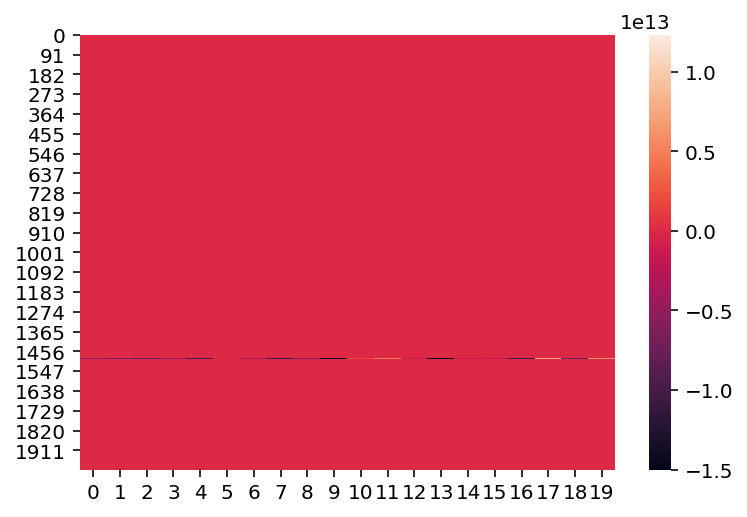

In [76]:
import sklearn.svm as svm
import sklearn
def test_svm(Xt, yt, Xv, yv):
    Cvals = [0.01, 0.1, 1, 10, 50, 75, 100, 1000, 10000, 100000]
    metrics = []
    clfs = []
    for C in Cvals:
        svc = svm.LinearSVC(C = C)
        svc.fit(Xt, yt)
        pred = svc.predict(Xt)
        prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yt, pred)
        print('C: {} training precision: {} recall: {} f1: {}'.format(C, prec[1], rec[1], f1[1]))
        pred = svc.predict(Xv)
        prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yv, pred)
        print('C: {} testing precision: {} recall: {} f1: {}'.format(C, prec[1], rec[1], f1[1]))

test_svm(XS_full, yS_full, XT_full, yT_full)
sns.heatmap(XS);

In [77]:
rps = np.sum(yS_full) / len(yS_full)
print('Random precision on source is {}'.format(rps))
print('Random f1 on source is {}'.format(2/(1/rps + 1)))
rpt = np.sum(yT_full) / len(yT_full)
print('Random precision on target is {}'.format(rpt))
print('Random f1 on target is {}'.format(2/(1/rpt + 1)))

Random precision on source is 0.05496773196274684
Random f1 on source is 0.1042074184780618
Random precision on target is 0.10555876765507557
Random f1 on target is 0.19096002988419875


2018-03-11 22:06:04,534 legend.py       WARNING   : No handles with labels found to put in legend.


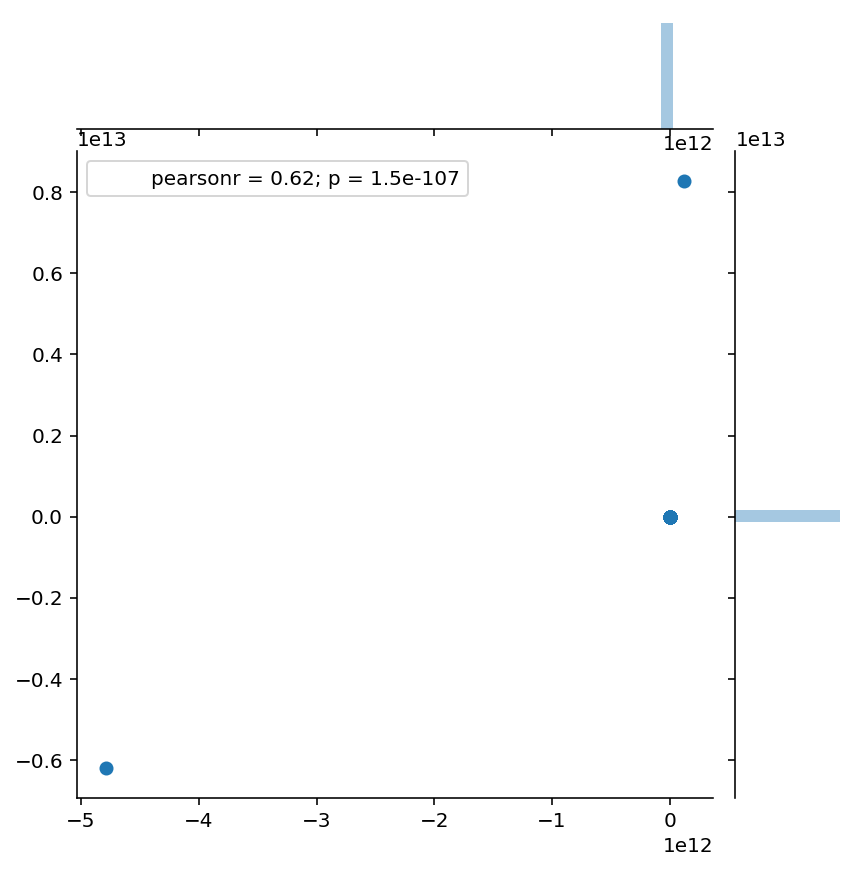

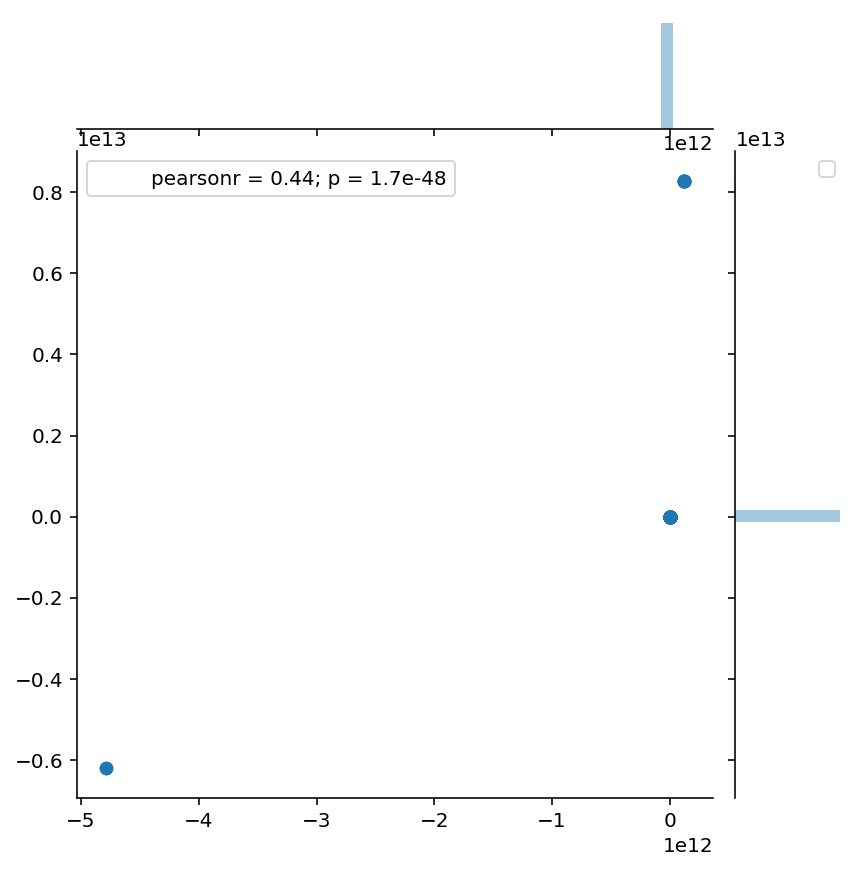

In [78]:
X_S_T = X_S[T_sample]
X_S_F = X_S[F_sample]
plt.figure()
sns.jointplot(X_S_T[:,0], X_S_T[:,1], label = 'T')
plt.figure()
sns.jointplot(X_S_F[:,0], X_S_F[:,1], label = 'F')
plt.legend(loc='best')

In [79]:
print(np.where(np.linalg.norm(X_S_T, axis=1) > 1000))
print(np.linalg.norm(X_S_T, axis=1)[np.where(np.linalg.norm(X_S_T, axis=1) > 1000)[0]])

(array([ 53,  97, 130, 151, 166, 178, 185, 204, 282, 288, 384, 399, 431,
       492, 509, 521, 546, 564, 606, 608, 663, 696, 700, 714, 782, 817,
       919, 920, 932, 962, 981]),)
[1.06991478e+03 1.06890466e+03 1.07098440e+03 1.06938849e+03
 1.06955267e+03 3.30733883e+13 1.06298991e+03 1.06975645e+03
 1.06865117e+03 1.06810351e+03 1.07211840e+03 1.06934555e+03
 1.06890466e+03 1.07148268e+03 1.06945974e+03 1.06298991e+03
 1.06854192e+03 1.06810351e+03 1.06955036e+03 1.06990755e+03
 1.07296562e+03 1.06918514e+03 1.07131120e+03 1.06991478e+03
 1.06972031e+03 1.06973258e+03 1.06932593e+03 2.59716756e+13
 1.06884643e+03 1.06955858e+03 1.06938849e+03]


In [80]:
XS_full, yS_full, XT_full, yT_full

XS_norm = np.linalg.norm(XS_full, axis=1)
XT_norm = np.linalg.norm(XT_full, axis=1)

print(np.sum(XS_norm > 1000))
print(np.sum(XT_norm > 1000))

XS_trim = XS_full[XS_norm < 1000]
yS_trim = yS_full[XS_norm < 1000]

1365
1472


In [81]:
test_svm(XS_trim, yS_trim, XT_full, yT_full)

/Users/markcrovella/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C: 0.01 training precision: 0.0 recall: 0.0 f1: 0.0
C: 0.01 testing precision: 0.12286158631415241 recall: 0.061815336463223784 f1: 0.08224882873503384
C: 0.1 training precision: 0.0 recall: 0.0 f1: 0.0
C: 0.1 testing precision: 0.09797570850202429 recall: 0.047339593114241005 f1: 0.06383539963070431
C: 1 training precision: 0.025052192066805846 recall: 0.0033826638477801266 f1: 0.005960511610579909
C: 1 testing precision: 0.1618181818181818 recall: 0.03482003129890454 f1: 0.05730843528654218
C: 10 training precision: 0.051378019734603604 recall: 0.02128259337561663 f1: 0.03009766792904126
C: 10 testing precision: 0.12742241925269157 recall: 0.3935837245696401 f1: 0.1925174624437853
C: 50 training precision: 0.05619084094763911 recall: 0.14474982381959126 f1: 0.08095538388775028
C: 50 testing precision: 0.11497299950908198 recall: 0.4581377151799687 f1: 0.18381602699945057
C: 75 training precision: 0.056874265569917745 recall: 0.034108527131782945 f1: 0.042643171806167404
C: 75 testing

In [82]:
T_sample_trim = np.random.choice(np.where(yS_trim)[0], 1000)
F_sample_trim = np.random.choice(np.where(~yS_trim)[0], 1000)
X_S_T = XS_trim[T_sample_trim]
X_S_F = XS_trim[F_sample_trim]
T_sample = np.random.choice(np.where(yT)[0], 1000)
F_sample = np.random.choice(np.where(~yT)[0], 1000)
X_T_T = XT_full[T_sample]
X_T_F = XT_full[F_sample]


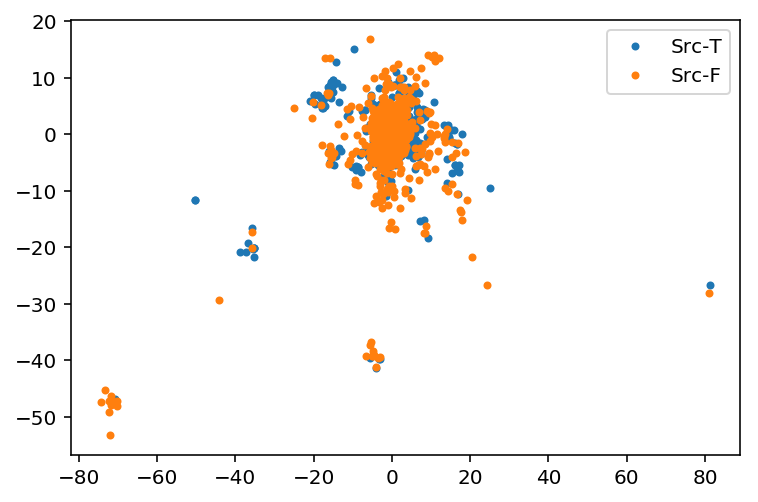

In [83]:
plt.plot(X_S_T[:,0], X_S_T[:,1], '.', label = 'Src-T')
plt.plot(X_S_F[:,0], X_S_F[:,1], '.', label = 'Src-F')
# plt.plot(X_T_T[:,0], X_T_T[:,1], '.', label = 'Tgt-T')
# plt.plot(X_T_F[:,0], X_T_F[:,1], '.', label = 'Tgt-F')
plt.legend(loc='best')

In [84]:
pred_T = svc.predict(XT_full)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yT_full, pred_T)
print("SVM on test set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))

NameError: name 'svc' is not defined

Nonetheless, when trained on target vectors, can do well.

In [85]:
svc = train_svm(XT, yT)
print('C value for this data: {}'.format(svc.C))
svc.fit(XT, yT)
pred_T = svc.predict(XT)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yT, pred_T)
print("SVM on training set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))

NameError: name 'train_svm' is not defined

In [86]:
pred_T = svc.predict(XT_full)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yT_full, pred_T)
print("SVM on test set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))

NameError: name 'svc' is not defined

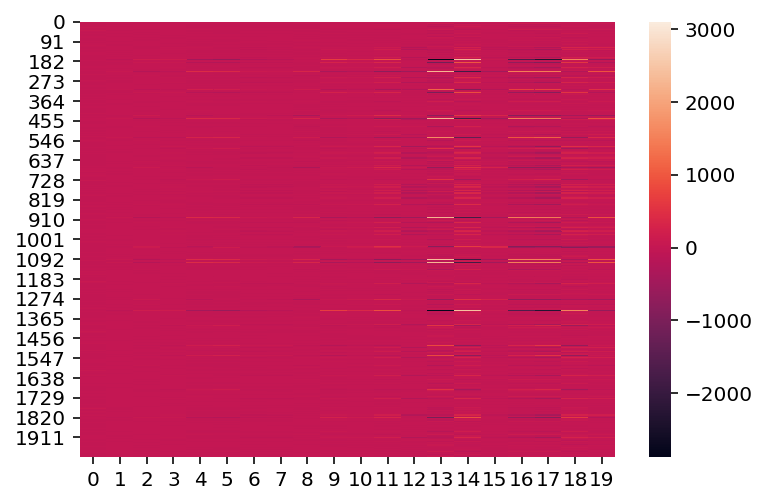

In [87]:
sns.heatmap(XT);

## CORAL 

Checking to make sure covariance of all data is not different from that of our sample.

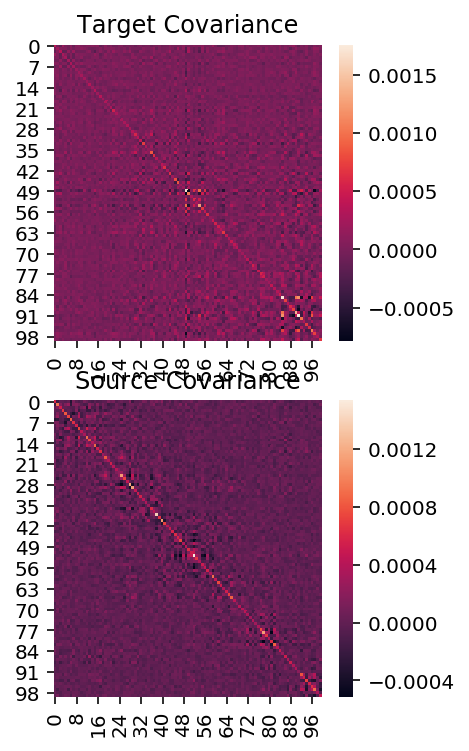

In [11]:
C1_centered = sklearn.preprocessing.scale(XS_full, with_std = False)
C2_centered = sklearn.preprocessing.scale(XT_full, with_std = False)

C1_cov = np.cov(XS_full.T)
C2_cov = np.cov(XT_full.T)

plt.figure(figsize=(3,6))
plt.subplot(2,1,1)
sns.heatmap(C2_cov)
plt.title('Target Covariance')
plt.subplot(2,1,2)
sns.heatmap(C1_cov)
plt.title('Source Covariance');

In [12]:
print('Rank of C1_cov is {}'.format(np.linalg.matrix_rank(C1_cov)))
print('Rank of C2_cov is {}'.format(np.linalg.matrix_rank(C2_cov)))

Rank of C1_cov is 100
Rank of C2_cov is 100


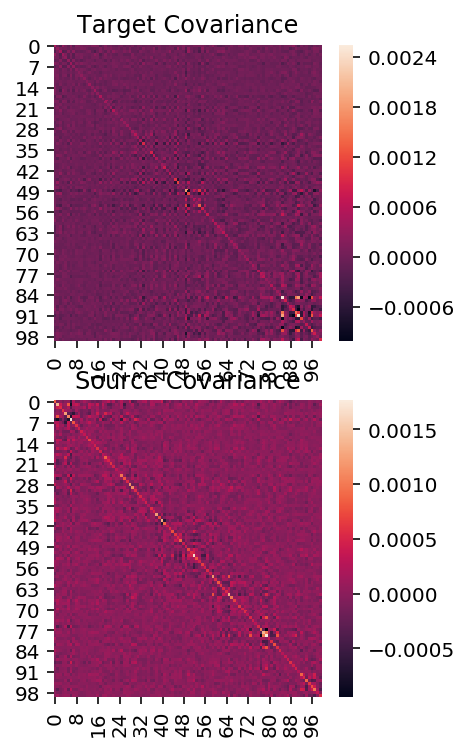

In [41]:
C1_centered = sklearn.preprocessing.scale(XS, with_std = False)
C2_centered = sklearn.preprocessing.scale(XT, with_std = False)
C2_full_centered = sklearn.preprocessing.scale(XT_full, with_std = False)

C1_cov = np.cov(XS.T)
C2_cov = np.cov(XT.T)

plt.figure(figsize=(3,6))
plt.subplot(2,1,1)
sns.heatmap(C2_cov)
plt.title('Target Covariance')
plt.subplot(2,1,2)
sns.heatmap(C1_cov)
plt.title('Source Covariance');

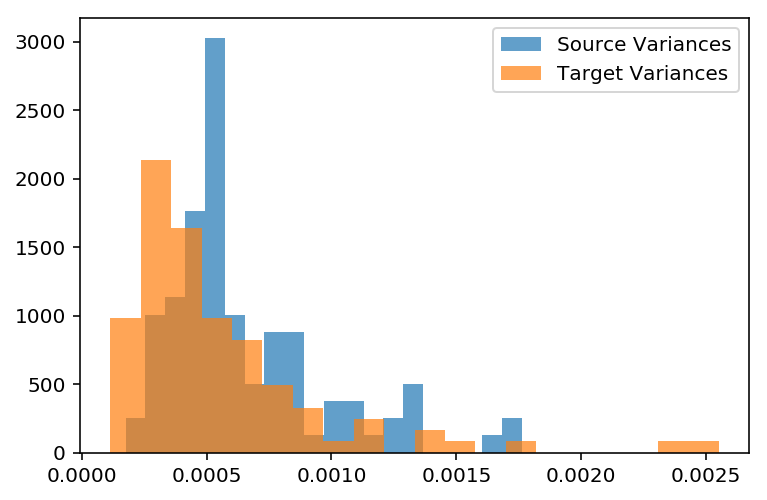

In [27]:
plt.hist(np.diag(C1_cov), density=True, label='Source Variances', bins=20, alpha=0.7)
plt.hist(np.diag(C2_cov), density=True, label='Target Variances', bins=20, alpha=0.7)
plt.legend(loc='best');

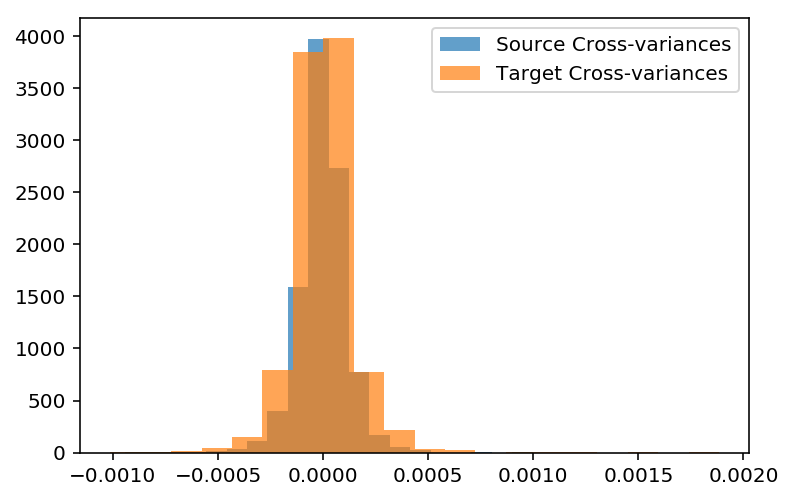

In [29]:
plt.hist(np.extract(1 - np.eye(C1_cov.shape[0]), C1_cov), label='Source Cross-variances', bins=20, alpha=0.7)
plt.hist(np.extract(1 - np.eye(C2_cov.shape[0]), C2_cov),label='Target Cross-variances', bins=20, alpha=0.7)
plt.legend(loc='best');

In [19]:
# regularize
lamb = 0.00001
CS = C1_cov + lamb * np.eye(*C1_cov.shape)
CT = C2_cov + lamb * np.eye(*C2_cov.shape)

source_to_target = True
if source_to_target:
    # this is the recommended approach in the coral paper
    CS_sqrt = np.real_if_close(sp.linalg.sqrtm(CS))
    DS = C1_centered @ np.linalg.pinv(CS_sqrt)
    NC_S = DS @ np.real_if_close(sp.linalg.sqrtm(CT))
else:
    # contrary to the coral paper we are 'fitting' the target distribution
    # into the source's distributional shape
    CT_sqrt = np.real_if_close(sp.linalg.sqrtm(CT))
    DT = C2_centered @ np.linalg.inv(CT_sqrt)
    NC_T = DT @ np.real_if_close(sp.linalg.sqrtm(CS))

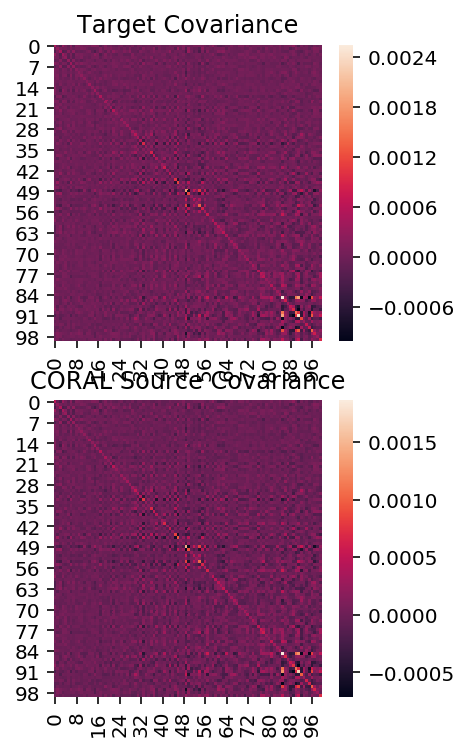

In [21]:
C1_Centered_CORAL = sklearn.preprocessing.scale(NC_S, with_std = False)
C1_cov_CORAL = np.cov(NC_S.T)
plt.figure(figsize=(3,6))
plt.subplot(2,1,1)
sns.heatmap(C2_cov)
plt.title('Target Covariance')
plt.subplot(2,1,2)
sns.heatmap(C1_cov_CORAL)
plt.title('CORAL Source Covariance');

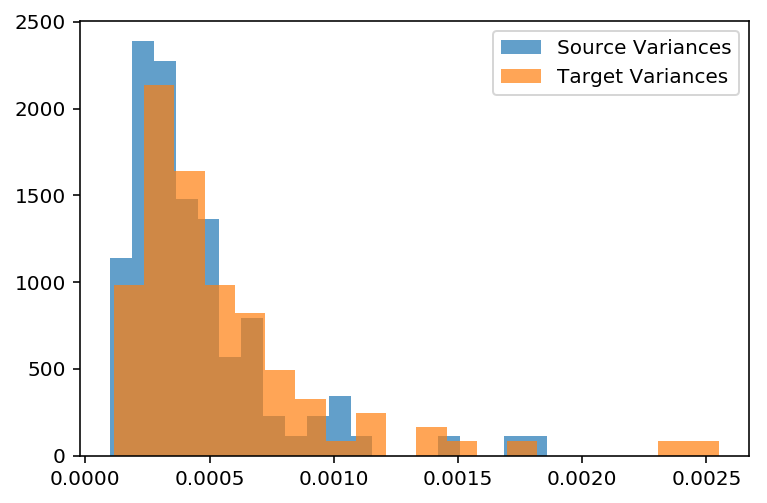

In [26]:
plt.hist(np.diag(C1_cov_CORAL), density=True, label='Source Variances', bins=20, alpha=0.7)
plt.hist(np.diag(C2_cov), density=True, label='Target Variances', bins=20, alpha=0.7)
plt.legend(loc='best');

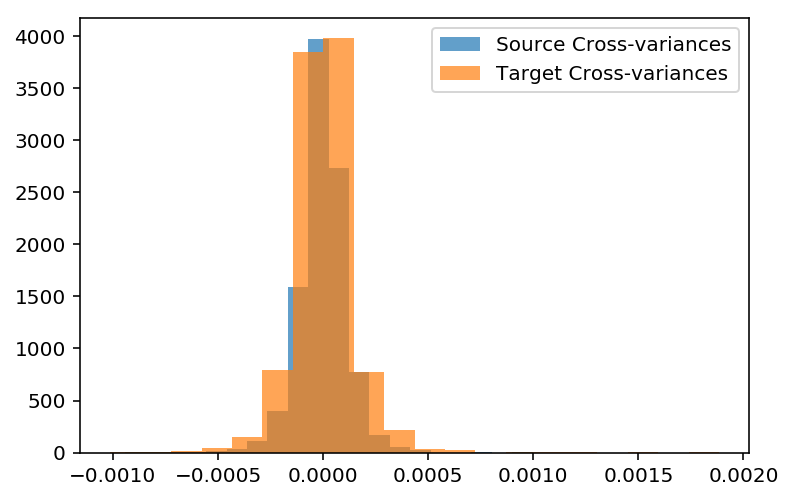

In [28]:
plt.hist(np.extract(1 - np.eye(C1_cov.shape[0]), C1_cov), label='Source Cross-variances', bins=20, alpha=0.7)
plt.hist(np.extract(1 - np.eye(C2_cov.shape[0]), C2_cov),label='Target Cross-variances', bins=20, alpha=0.7)
plt.legend(loc='best')

In [43]:
def train_svm(X, y):
    Cvals = [10000] #[0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
    metrics = []
    clfs = []
    for C in Cvals:
        svc = svm.SVC(kernel='linear', C = C)
        svc.fit(X, y)
        pred = svc.predict(X)
        if 1 in pred:
            metrics.append(sklearn.metrics.f1_score(y, pred))
        else:
            metrics.append(0)
        clfs.append(svc)
    best = np.where(metrics == max(metrics))
    return clfs[best[0][0]]

svc = train_svm(C1_Centered_CORAL, yS)
print('C value for this data: {}'.format(svc.C))
svc.fit(C1_Centered_CORAL, yS)
pred_S = svc.predict(C1_Centered_CORAL)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yS, pred_S)
print("SVM on CORALIZED source set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))
#
pred_T = svc.predict(C2_centered)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yT, pred_T)
print("SVM on target set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))
#
pred_T = svc.predict(C2_full_centered)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(yT_full, pred_T)
print("SVM on test set: precision {}, recall {}, f1 {}.".format(prec[1], rec[1], f1[1]))

C value for this data: 10000
SVM on CORALIZED source set: precision 0.7025, recall 0.562, f1 0.6244444444444446.
SVM on target set: precision 0.47150259067357514, recall 0.455, f1 0.4631043256997456.
SVM on test set: precision 0.09363896848137536, recall 0.4166241713411525, f1 0.15291034999064199.
